<a href="https://colab.research.google.com/github/Saroramath/MachineLearning/blob/main/TransferLearningCIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
train_ds, val_ds, test_ds = tfds.load(
    'cifar10',
    split=['train[:90%]', 'train[90%:100%]', 'test'],
    as_supervised=True
)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteCWFUGS/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteCWFUGS/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# Verify that each dataset has the right number of elements:
print("Training samples: {}, Validation samples: {}, Test samples: {}".format(
    tf.data.experimental.cardinality(train_ds), tf.data.experimental.cardinality(val_ds),
    tf.data.experimental.cardinality(test_ds)
))

Training samples: 45000, Validation samples: 5000, Test samples: 10000


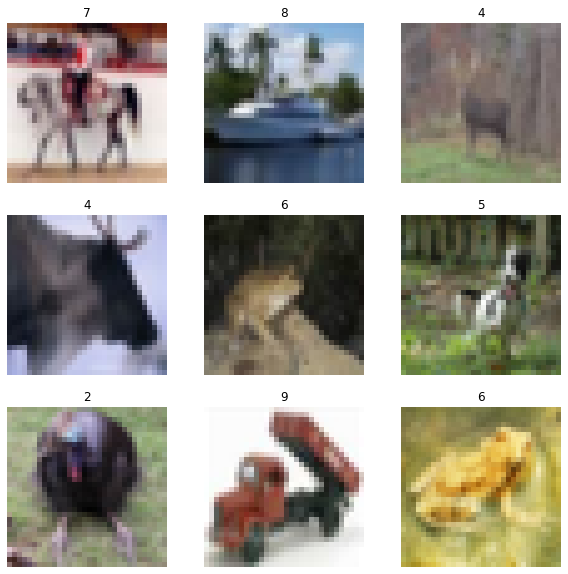

In [ ]:
# Plot some images of the dataset
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_ds.take(9)):
  plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis('off')

In [ ]:
# Image size to rescale to
size = (150, 150)

# Preprocess the data
def preprocessing(X, y):
  return tf.image.resize_with_crop_or_pad(X, size[0], size[1]), tf.one_hot(y, 10)

# Data preprocessing (resizing the images, one-hot encode the labels)
train_ds = train_ds.map(preprocessing)
val_ds = val_ds.map(preprocessing)
test_ds = test_ds.map(preprocessing)

In [ ]:
# Batch, cache and prefetch the data
batch_size = 32
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# Get the base model
base_model = tf.keras.applications.DenseNet121(
    weights='imagenet', # Pre-trained weights on ImageNet dataset
    input_shape=(size[0],size[1],3), # Image shape of resized CIFAR10
    include_top=False, # Do not include the classifier part (we write our own)
)

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
# Get summary of base model
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
# Base model should not be updated (i.e. we freeze the weights)
base_model.trainable = False

In [ ]:
# We create our model
inp = tf.keras.layers.Input(shape=(size[0],size[1],3))

# Inputs needs to be pre-processed for base model
b = tf.keras.layers.Lambda(tf.keras.applications.densenet.preprocess_input)(inp)

# Pass inputs in the base model (training false means the model is used in
# inference mode, which will allow us fine tuning after initial training)
b = base_model(b, training=False)

# We need to implement a new classifier. For this need to flatten the output
# of the base_model
b = tf.keras.layers.Flatten()(b)

# This is the actual classifier
b = tf.keras.layers.BatchNormalization()(b)
b = tf.keras.layers.Dense(256, activation='relu')(b)
b = tf.keras.layers.Dropout(0.3)(b)

b = tf.keras.layers.BatchNormalization()(b)
b = tf.keras.layers.Dense(128, activation='relu')(b)
b = tf.keras.layers.Dropout(0.3)(b)

b = tf.keras.layers.BatchNormalization()(b)
b = tf.keras.layers.Dense(64, activation='relu')(b)
b = tf.keras.layers.Dropout(0.3)(b)

# Output is a dense classifier with softmax activation
out = tf.keras.layers.Dense(10, activation='softmax')(b)

# Create model
model = tf.keras.models.Model(inp, out)

# Note how few parameters have to be trained by the model!
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 150, 150, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
dense (Dense)                (None, 256)               4194560   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
# Now train the top part of the model (the classifier layer) as usual
model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
1407/1407 [==============================] - 71s 42ms/step - loss: 1.6460 - acc: 0.4359 - val_loss: 0.9256 - val_acc: 0.6730
Epoch 2/20
1407/1407 [==============================] - 56s 40ms/step - loss: 1.1031 - acc: 0.6289 - val_loss: 0.8454 - val_acc: 0.6988
Epoch 3/20
1407/1407 [==============================] - 56s 40ms/step - loss: 0.9867 - acc: 0.6650 - val_loss: 0.8181 - val_acc: 0.7120
Epoch 4/20
1407/1407 [==============================] - 56s 40ms/step - loss: 0.9117 - acc: 0.6917 - val_loss: 0.7975 - val_acc: 0.7182
Epoch 5/20
1407/1407 [==============================] - 56s 40ms/step - loss: 0.8551 - acc: 0.7091 - val_loss: 0.8124 - val_acc: 0.7220
Epoch 6/20
1407/1407 [==============================] - 56s 40ms/step - loss: 0.8372 - acc: 0.7219 - val_loss: 0.9803 - val_acc: 0.7146
Epoch 7/20
1407/1407 [==============================] - 56s 40ms/step - loss: 0.7807 - acc: 0.7356 - val_loss: 0.7797 - val_acc: 0.7296
Epoch 8/20
1407/1407 [==========================

In [ ]:
test_loss, test_acc = model.evaluate(train_ds)
print("Test accuracy: {}".format(test_acc))

1407/1407 [==============================] - 49s 35ms/step - loss: 0.3058 - acc: 0.8989
Test accuracy: 0.8989111185073853


In [ ]:
# Now fine-tune the model by training the entire model (note that the base model
# still uses training=False which keeps the statistics for the batch norm layers
# frozen, which preserves the representation learned by the model)
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 150, 150, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
dense (Dense)                (None, 256)               4194560   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

In [ ]:
# Compile full model again, but with a really low learning rate to not overfit!
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss='categorical_crossentropy',
    metrics=['acc'],
)

In [ ]:
# Train again for a few epochs
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1407/1407 [==============================] - 194s 129ms/step - loss: 0.4381 - acc: 0.8521 - val_loss: 0.9848 - val_acc: 0.7292
Epoch 2/10
1407/1407 [==============================] - 180s 128ms/step - loss: 0.4363 - acc: 0.8528 - val_loss: 0.9927 - val_acc: 0.7178
Epoch 3/10
1407/1407 [==============================] - 180s 128ms/step - loss: 0.4434 - acc: 0.8509 - val_loss: 0.9410 - val_acc: 0.7350
Epoch 4/10
1407/1407 [==============================] - 179s 128ms/step - loss: 0.4118 - acc: 0.8599 - val_loss: 1.0896 - val_acc: 0.6794
Epoch 5/10
1407/1407 [==============================] - 180s 128ms/step - loss: 0.4107 - acc: 0.8607 - val_loss: 0.9277 - val_acc: 0.7400
Epoch 6/10
1407/1407 [==============================] - 180s 128ms/step - loss: 0.4171 - acc: 0.8601 - val_loss: 0.8723 - val_acc: 0.7496
Epoch 7/10
1407/1407 [==============================] - 180s 128ms/step - loss: 0.4078 - acc: 0.8633 - val_loss: 0.8804 - val_acc: 0.7476
Epoch 8/10
1407/1407 [============

In [ ]:
# Evaluate again on the test data set:
test_loss_ft, test_acc_ft = model.evaluate(train_ds)
print("Test accuracy original transfer learning: {}".format(test_acc))
print("Test accuracy fine tuned model: {}".format(test_acc_ft))

1407/1407 [==============================] - 49s 35ms/step - loss: 0.2931 - acc: 0.9028
Test accuracy original transfer learning: 0.8989111185073853
Test accuracy fine tuned model: 0.9027555584907532
